# AI Agent Bhorali

In [7]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from IPython.display import Image

# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt.chat_agent_executor import AgentState
import requests
from pydantic import BaseModel, Field

# web3
from web3 import Web3
from solana.rpc.async_api import AsyncClient
import asyncio
import base64

In [56]:
# model = ChatOpenAI(model="gpt-4o", temperature=0)

# # pydantic
# class PersonSchema(BaseModel):
#     """Details of the person"""

#     name: str = Field(description="Name of the person")
#     age: int = Field(description="age in years of the person")
#     height: float = Field(description="height in feet and inch")
#     wives: list[str] = Field(description="list of names of the present and past wives")
#     news: list[str] = Field(description="list of what the person did interesting in the last week, with dates provided.")


# structured_llm = model.with_structured_output(PersonSchema)

# structured_llm.invoke("tell me about Diana")

In [27]:
class TokenSchema(BaseModel):
    """Details of the token"""
    name: str = Field(description="Name of the token")
    address: str = Field(description="Address of the token")
    chain: str = Field(description="Chain of the token")
    price: float = Field(description="Price of the token")
    market_cap: float = Field(description="Market cap of the token")
    volume: float = Field(description="Volume 24h) of the token")
    liquidity: float = Field(description="Liquidity of the token")

    # fill the below only after the token is assessed
    news: List[str] = Field(description="List of news related to the token")
    team_verification: Optional[str] = Field(description="If team is verified, return team details, otherwise return None")
    red_flags: Optional[List[str]] = Field(description="List of red flags for the token if any, otherwise return None")

class TokenSchemas(BaseModel):
    coins: List[TokenSchema]

class State(TypedDict):
    task: str 
    coins_to_invest: TokenSchemas
    coins_risk_assessed: TokenSchemas
    

def get_top_dexscreener_coins():
    '''Get the top 30 tokens on dexscreener'''
    chain_id = "solana"

    # Get the tokens with most active boosts on dexscreener (rate-limit 60 requests per minute)
    response = requests.get(
        "https://api.dexscreener.com/token-boosts/top/v1",
        headers={},
    )
        
    data = response.json()

    # Extract token addresses from the response data
    token_addresses = [item["tokenAddress"] for item in data if item["chainId"] == chain_id]

    response = requests.get(
        f"https://api.dexscreener.com/tokens/v1/{chain_id}/{','.join(token_addresses)}",
        headers={},
    )

    data = response.json()
    
    # return Command(
    #     update = {
    #         "messages": [
    #             ToolMessage(f'Successfully fetched top 30 tokens on dexscreener, {data}', tool_call_id=tool_call_id)
    #         ]
    #     }
    # )

    return f'Top 30 tokens on dexscreener: {data}'




search_tool = TavilySearchResults(max_results=4)

coins_prompt = """You are an expert DEX Trading Analysis AI specializing in identifying short-term cryptocurrency opportunities. Analyze DEXScreener data and filter out the high-potential tokens (maximum 4) by examining price action, volume, liquidity, and holder patterns. 
For each recommendation, provide: token details (address, chain, price), key metrics (market cap, volume, liquidity)."""

risk_assessment_prompt = """You are an expert risk analyst for DEX Trading. 
                            Search the web (using the web search tool you have), 
                            for the tokens and asses the team verification, 
                            any relevant news, potential red flags for the tokens.
                            Update only the relevant fields in the output schema.
"""


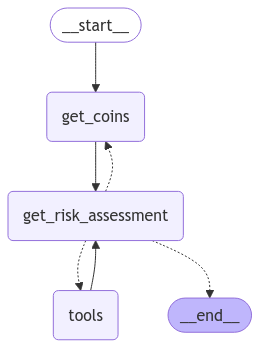

In [28]:
tools = [search_tool]

class Agent:

    def __init__(self, model):
        graph_builder = StateGraph(State)
        self.llm = model
        self.llm = model.bind_tools(tools)

        # set_llm_cache(SQLiteCache(database_path=".langchain.db"))
        # memory = SqliteSaver.from_conn_string(":memory:")
        memory = MemorySaver()

        tool_node = ToolNode(tools)

        graph_builder.add_node("get_coins", self.get_coins_node)
        graph_builder.add_node("get_risk_assessment", self.get_risk_assessment_node)
        # graph_builder.add_node("tools", tool_node)

        graph_builder.add_edge(START, "get_coins")
        graph_builder.add_edge("get_coins", "get_risk_assessment")
        graph_builder.add_edge("get_risk_assessment", END)

        # graph_builder.add_conditional_edges(
        #     "get_risk_assessment",
        #     self.route_tools,
        # )

        # graph_builder.add_edge("tools", "get_risk_assessment")
        
        self.graph = graph_builder.compile(checkpointer=memory)

    
    def get_coins_node(self, state: State):
        dexscreener_coins = get_top_dexscreener_coins()
        # messages = [
        #     SystemMessage(content=coins_prompt),
        #     HumanMessage(content=state['task']),
        #     HumanMessage(content=dexscreener_coins),
        # ]

        prompt = f"""
        {coins_prompt}
        
        Task: {state['task']}
        
        Data: {dexscreener_coins}
        """

        response = self.llm.with_structured_output(TokenSchemas).invoke(prompt)

        print("Response Coins to Invest: ")

        return {"coins_to_invest": response}
    
    def get_risk_assessment_node(self, state: State):
        # messages = [
        #     SystemMessage(content=risk_assessment_prompt),
        #     HumanMessage(content=state["coins_to_invest"]),
        # ]

        prompt = f"""
        {risk_assessment_prompt}
        
        Tokens to analyze: {state['coins_to_invest']}
        """

        response = self.llm.with_structured_output(TokenSchemas).invoke(prompt)

        print("Response Risk Assessment: ")

        return {"coins_risk_assessed": response}
        
    
    def show_graph(self):
        return Image(self.graph.get_graph().draw_mermaid_png())
    
    def stream_graph_updates(self, config, user_input: str):
        for event in self.graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values",
        ):
            # for value in event.values():
            event["messages"][-1].pretty_print()

    def route_tools(self, state: State):
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get("messages", []):
            ai_message = messages[-1]
        else:
            raise ValueError("No AI messages found in input state: {state}")

        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"
        return END
    

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = Agent(model)

agent.show_graph()

In [29]:
thread = {"configurable": {"thread_id": "1"}}

# events = agent.graph.stream(
#     {"task": "get me coins to BUY"},
#     thread,
#     stream_mode="values",
# )

# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

for s in agent.graph.stream({
    'task': "suggest me coins to BUY",
}, thread):
    (print(s))

Response Coins to Invest: 
{'get_coins': {'coins_to_invest': TokenSchemas(coins=[TokenSchema(name='Straight Tuah Jail', address='6uGrKeFiTccSi4JdTQnfu43bn4p5A8qnSqSbABampump', chain='solana', price=0.0001522, market_cap=152224.0, volume=8960381.67, liquidity=55435.96, news=[], team_verification=None, red_flags=None), TokenSchema(name='JailMurad', address='644MryX1MXBNjA8QEUNeQ5HSEVZZqGRzPdiLz4EBpump', chain='solana', price=0.0002477, market_cap=247714.0, volume=28705071.99, liquidity=78838.44, news=[], team_verification=None, red_flags=None), TokenSchema(name='Republic Of Congo Meme', address='B5oWu9AntBHKv1rStTEDNncxoFNUDJNVEtUshGxzpump', chain='solana', price=4.342e-05, market_cap=43422.0, volume=520696.56, liquidity=24344.51, news=[], team_verification=None, red_flags=None), TokenSchema(name='Jail Melania', address='kvpi4ogX3PHrcgx1UKviBNHSbh9RWCfvDj5Rwnapump', chain='solana', price=3.117e-05, market_cap=31175.0, volume=1389116.51, liquidity=21557.12, news=[], team_verification=None

ValueError: No AI messages found in input state: {state}